# Appendix C: Code and it's Outputs


In [16]:
import glob
import os

reports_path = 'C:/Users/Sujan Tumbaraguddi/Desktop/Data Science/Assignments/3_7150 - Project/DATA/reports'
summaries_path = 'C:/Users/Sujan Tumbaraguddi/Desktop/Data Science/Assignments/3_7150 - Project/DATA/summaries'

def read_text_files(path):
    """
    Reads all text files from the specified folder and returns a dictionary with file names as keys and content as values.
    """
    #print(path)
    paths = glob.glob(os.path.join(path, "*.txt"))
    #print('File Paths: ', paths)
    #print(type(paths))
    documents = {}
    for path in paths:
        with open(path, encoding='utf-8') as file:
            documents[os.path.basename(path)] = file.read()
    #print(documents.keys())
    #print(documents.values())
    return documents

# Read text files from the specified folder
reports = read_text_files(reports_path)
#print('reports: ',reports.keys())
#print('reports: ',reports.values())

summaries = read_text_files(summaries_path)
#print('summaries: ',summaries.keys())
#print('summaries: ',summaries.values())

In [17]:
import numpy as np
import networkx as nx
import pandas as pd
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BartForConditionalGeneration, BartTokenizer
from rouge_score import rouge_scorer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import sacrebleu

def extractive_summarization(text, num_sentences=3):
    """
    Performs extractive summarization by selecting the top sentences based on cosine similarity scores.
    """
    sentences = sent_tokenize(text)
    #print(sentences)
    #print(type(sentences))
    if len(sentences) <= num_sentences:   #check if num of sentences are more than 3 in the report
        return text

    vectorizer = CountVectorizer().fit_transform(sentences)
    vectors = vectorizer.toarray()
    #print(vectors)
    cosine_matrix = cosine_similarity(vectors)
    #print(cosine_matrix)
    #print('--------------------------------------------------------')
    nx_graph = nx.from_numpy_array(cosine_matrix)
    scores = nx.pagerank(nx_graph)
    #print(scores)              #array
    ranked_sentences = [sentences[i] for i in np.argsort(scores, axis=0)[-num_sentences:]]
    #print(ranked_sentences)    #list
    return ' '.join(ranked_sentences)    #String


bart_model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn') #(facebook/bart-large), (facebook/bart-base)
bart_tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')

def chunk_text(text, max_length, tokenizer):
    """
    Splits the text into chunks of the specified maximum length.
    """
    sentences = sent_tokenize(text)
    chunks = []
    current_chunk = ""
    
    for sentence in sentences:
        if len(tokenizer.encode(current_chunk + sentence, truncation=True)) <= max_length:
            current_chunk += " " + sentence
            #print(current_chunk)
        else:
            chunks.append(current_chunk.strip())
            current_chunk = sentence
    
    if current_chunk:
        chunks.append(current_chunk.strip())
    #print(chunks)
    
    return chunks

def abstractive_summarization(text, model, tokenizer, max_length=1024):
    """
    Performs abstractive summarization using the BART model with chunking.
    """
    chunks = chunk_text(text, max_length, tokenizer)
    summaries = []

    for chunk in chunks:
        inputs = tokenizer.encode("summarize: " + chunk, return_tensors="pt", max_length=max_length, truncation=True)
        summary_ids = model.generate(inputs, max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
        summaries.append(tokenizer.decode(summary_ids[0], skip_special_tokens=True))
    
    combined_summary = " ".join(summaries)

    if len(tokenizer.encode(combined_summary, truncation=True)) > max_length:
        return abstractive_summarization(combined_summary, model, tokenizer, max_length)

    return combined_summary

def save_summary(summary, output_folder, filename):
    """
    Saves the given summary text to a specified folder with the given filename.
    """
    output_path = os.path.join(output_folder, filename)
    with open(output_path, 'w', encoding='utf-8') as file:
        file.write(summary)
    
def evaluate_summaries(reference, extractive, abstractive):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    extractive_scores = scorer.score(reference, extractive)
    abstractive_scores = scorer.score(reference, abstractive)
    bleu_extractive = sacrebleu.corpus_bleu([extractive], [[reference]])
    bleu_abstractive = sacrebleu.corpus_bleu([abstractive], [[reference]])
    '''print("Extractive Summary Scores:")
    print('rouge1:',extractive_scores['rouge1'].precision)
    print('rouge2:',extractive_scores['rouge2'].precision)
    print('rougeL:',extractive_scores['rougeL'].precision, '\n')
    print("BLEU Score:", bleu_extractive.score)
    print("Abstractive Summary Scores:")
    print('rouge1:',abstractive_scores['rouge1'].precision)
    print('rouge2:',abstractive_scores['rouge2'].precision)
    print('rougeL:',abstractive_scores['rougeL'].precision)
    print("BLEU Score:", bleu_abstractive.score, '\n')'''
    return extractive_scores, abstractive_scores, bleu_extractive, bleu_abstractive

# Sentiment analysis with VADER
def sentiment_analysis(text):
    analyzer = SentimentIntensityAnalyzer()
    scores = analyzer.polarity_scores(text)
    return scores['compound'], scores['pos'] - scores['neg']  # Compound score and polarity difference

results = []

for doc_name in reports:
        if doc_name in summaries:
            extractive_output_folder_path = r'C:\Users\Sujan Tumbaraguddi\Desktop\Data Science\Assignments\3_7150 - Project\DATA\Gen_extractive'
            abstractive_output_folder_path = r'C:\Users\Sujan Tumbaraguddi\Desktop\Data Science\Assignments\3_7150 - Project\DATA\Gen_abstractive'
            doc = reports[doc_name]
            reference_summary = summaries[doc_name]
            
            # extractive summarization
            extractive_summary = extractive_summarization(doc)
            print(doc_name)
            #print('Extractive Summary of ', doc_name, ': \n', extractive_summary)
            #print('---------------------------------------------------------------------------')
            #print(type(extractive_summary))
            
            # abstractive summarization
            abstractive_summary = abstractive_summarization(doc, bart_model, bart_tokenizer)
            #print('Abstractive Summary of  ', doc_name, ': \n', abstractive_summary)
            #print('----------------------------------------------------------------------------')
            #print(type(abstractive_summary))
            
            # Save summaries to respective output folders
            #save_summary(extractive_summary, extractive_output_folder_path, f"extractive_{doc_name}")
            #save_summary(abstractive_summary, abstractive_output_folder_path, f"abstractive_{doc_name}")
            
            #ROUGE and BLEU metrics
            extractive_scores, abstractive_scores, bleu_extractive, bleu_abstractive = evaluate_summaries(extractive_summary, abstractive_summary, reference_summary)
            
            #sentiment analysis
            extractive_sentiment = sentiment_analysis(extractive_summary)
            abstractive_sentiment = sentiment_analysis(abstractive_summary)
            
            results.append({
                'Document Name': doc_name,
                'Original Text': doc,
                'Reference Summary': reference_summary,
                'Extractive Summary': extractive_summary,
                'Abstractive Summary': abstractive_summary,
                'Extractive ROUGE-1': extractive_scores['rouge1'].fmeasure,
                'Extractive ROUGE-2': extractive_scores['rouge2'].fmeasure,
                'Extractive ROUGE-L': extractive_scores['rougeL'].fmeasure,
                'Abstractive ROUGE-1': abstractive_scores['rouge1'].fmeasure,
                'Abstractive ROUGE-2': abstractive_scores['rouge2'].fmeasure,
                'Abstractive ROUGE-L': abstractive_scores['rougeL'].fmeasure,
                'Extractive BLEU': bleu_extractive.score,
                'Abstractive BLEU': bleu_abstractive.score,
                'Extractive Sentiment Polarity': extractive_sentiment[0],
                'Extractive Sentiment Subjectivity': extractive_sentiment[1],
                'Abstractive Sentiment Polarity': abstractive_sentiment[0],
                'Abstractive Sentiment Subjectivity': abstractive_sentiment[1],
            })

# Save the results to a CSV file
csv_output_path = r'C:\Users\Sujan Tumbaraguddi\Desktop\Data Science\Assignments\3_7150 - Project\DATA\NTuned_summarized_reports_evaluation.csv'
df = pd.DataFrame(results)
df.to_csv(csv_output_path, index=False)

01.txt
02.txt
03.txt
04.txt
05.txt
06.txt
07.txt
08.txt
09.txt
10.txt
11.txt
12.txt
13.txt
14.txt
15.txt
16.txt
17.txt
18.txt
19.txt
20.txt
21.txt
22.txt
23.txt
24.txt
25.txt
26.txt
27.txt
28.txt
29.txt
30.txt
31.txt
32.txt
33.txt
34.txt
35.txt
36.txt
37.txt
38.txt
39.txt
40.txt
41.txt
42.txt
43.txt
44.txt
45.txt
46.txt
47.txt
48.txt
49.txt
50.txt
51.txt
52.txt
53.txt
54.txt


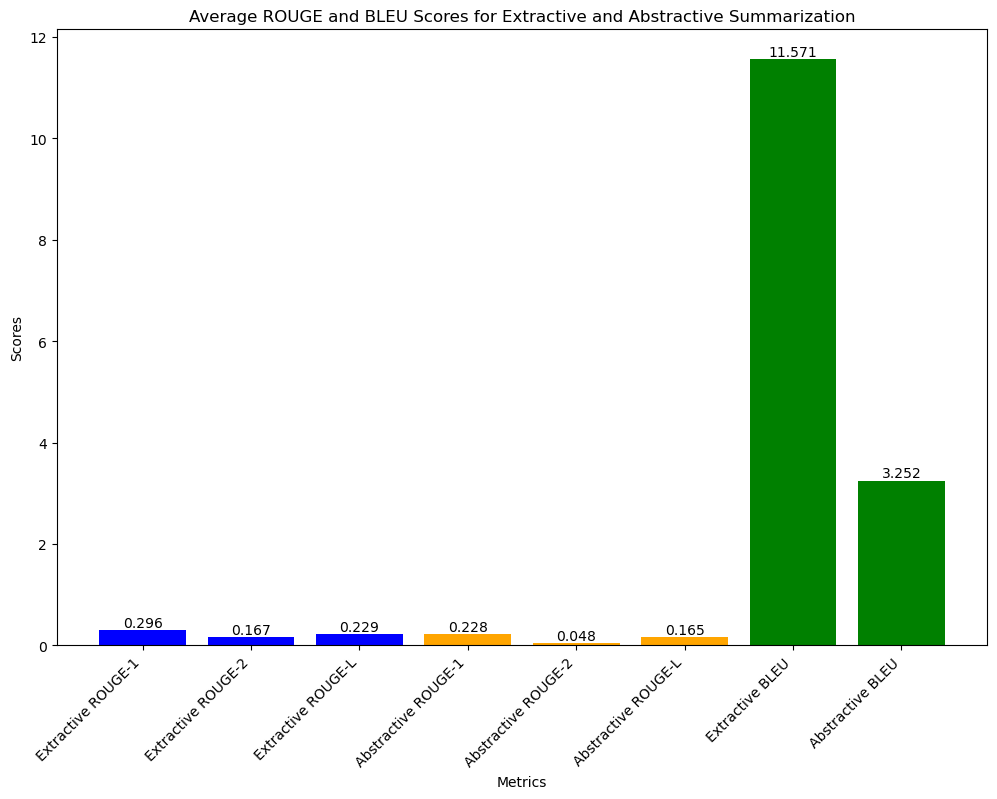

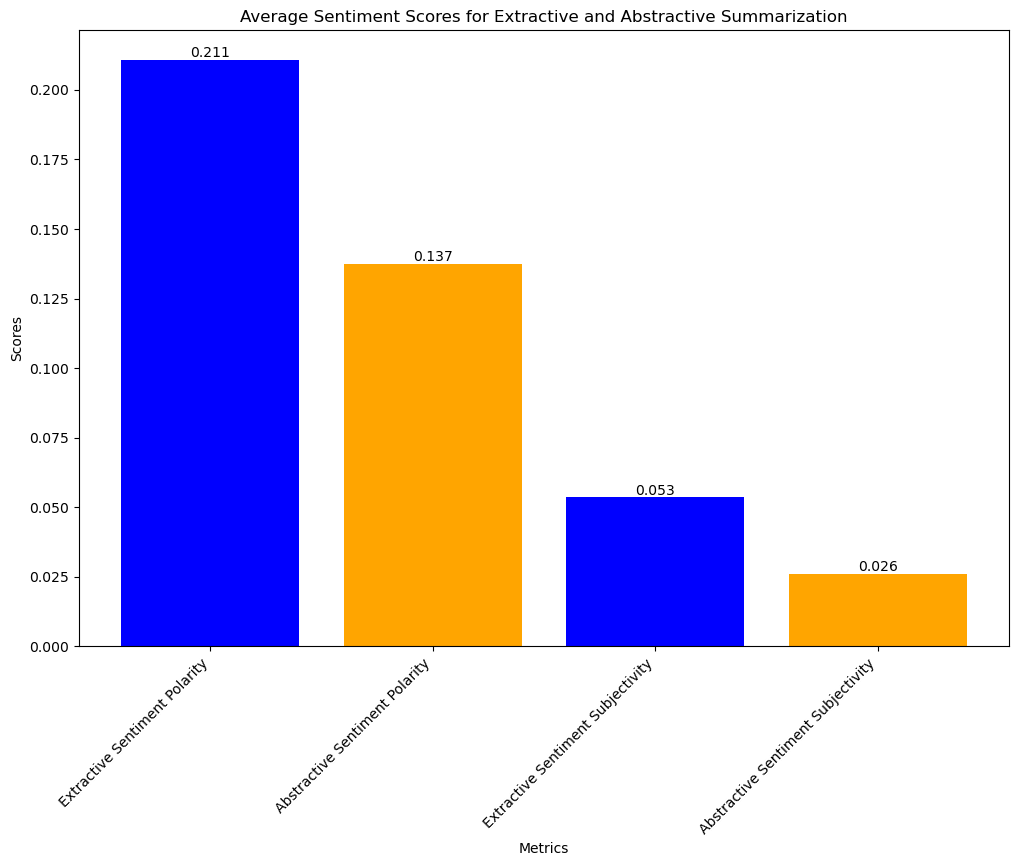

In [18]:
import matplotlib.pyplot as plt

# Calculate average ROUGE and BLEU scores
average_scores = {
    'Extractive ROUGE-1': df['Extractive ROUGE-1'].mean(),
    'Extractive ROUGE-2': df['Extractive ROUGE-2'].mean(),
    'Extractive ROUGE-L': df['Extractive ROUGE-L'].mean(),
    'Abstractive ROUGE-1': df['Abstractive ROUGE-1'].mean(),
    'Abstractive ROUGE-2': df['Abstractive ROUGE-2'].mean(),
    'Abstractive ROUGE-L': df['Abstractive ROUGE-L'].mean(),
    'Extractive BLEU': df['Extractive BLEU'].mean(),
    'Abstractive BLEU': df['Abstractive BLEU'].mean()
}

# Compare ROUGE and BLEU scores
plt.figure(figsize=(12, 8))
bars = plt.bar(average_scores.keys(), average_scores.values(), color=['blue', 'blue', 'blue', 'orange', 'orange', 'orange', 'green', 'green'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Average ROUGE and BLEU Scores for Extractive and Abstractive Summarization')

# Add value labels on bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), ha='center', va='bottom')

plt.show()

# Compare Sentiment Scores
sentiment_scores = {
    'Extractive Sentiment Polarity': df['Extractive Sentiment Polarity'].mean(),
    'Abstractive Sentiment Polarity': df['Abstractive Sentiment Polarity'].mean(),
    'Extractive Sentiment Subjectivity': df['Extractive Sentiment Subjectivity'].mean(),
    'Abstractive Sentiment Subjectivity': df['Abstractive Sentiment Subjectivity'].mean()
}

plt.figure(figsize=(12, 8))
bars = plt.bar(sentiment_scores.keys(), sentiment_scores.values(), color=['blue', 'orange', 'blue', 'orange'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Average Sentiment Scores for Extractive and Abstractive Summarization')

# Add value labels on bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), ha='center', va='bottom')

plt.show()



In [3]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
print(stop_words)

{'myself', 'all', 'here', 'wasn', 'hers', 'yourself', 'her', 'himself', 'was', 'with', 'own', 'not', 'yourselves', 'very', "it's", 'hadn', 'these', 'so', 'from', 'me', 'how', 'when', 'isn', 'wouldn', 'him', 'and', "mightn't", 'it', 'does', 'an', 'itself', 'haven', "you're", 'both', "shan't", 'hasn', 'ma', 'y', "isn't", 'our', 'further', 'who', "you'll", 'a', 'he', 'out', "she's", "should've", 'ain', 'the', 'that', 'just', 'be', 'until', 've', 'below', 'am', 'didn', 'i', 'more', 'only', 'o', 'did', 'again', 'don', 'are', 't', 'other', 'this', 'some', 'while', 'm', 'should', 'during', 'needn', 'most', 'have', "that'll", 'doesn', 'in', 'nor', 'now', "wasn't", 'there', 'or', 'ours', 'mightn', 'such', "won't", 'she', 'themselves', 'you', 'is', 'ourselves', 'each', 'no', 'which', 'up', 'won', 'on', 'being', "hadn't", 'by', 'against', 'same', 'at', 'for', "you've", 'we', 'to', 'theirs', 'its', 'as', 'can', 'couldn', 'had', 'my', 'then', "didn't", "haven't", 'doing', 'weren', 'once', 'has', 'i

In [9]:
import glob
import os
import re
import numpy as np
import networkx as nx
import pandas as pd
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk import ne_chunk, pos_tag
from nltk.tree import Tree
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BartForConditionalGeneration, BartTokenizer
from rouge_score import rouge_scorer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import sacrebleu
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

# Paths
reports_path = 'C:/Users/Sujan Tumbaraguddi/Desktop/Data Science/Assignments/3_7150 - Project/DATA/reports'
summaries_path = 'C:/Users/Sujan Tumbaraguddi/Desktop/Data Science/Assignments/3_7150 - Project/DATA/summaries'

# Text Cleaning and Normalization
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    text = re.sub(r'\W', ' ', text)   # Remove non-alphanumeric characters
    #text = ' '.join(word for word in text.split() if word.lower() not in stop_words)  # Remove stopwords
    return text

# Read text files
def read_text_files(path):
    paths = glob.glob(os.path.join(path, "*.txt"))
    documents = {}
    for path in paths:
        with open(path, encoding='utf-8') as file:
            documents[os.path.basename(path)] = clean_text(file.read())
    return documents

# Named Entity Recognition (NER)
def get_named_entities(text):
    chunked = ne_chunk(pos_tag(word_tokenize(text)))
    continuous_chunk = []
    current_chunk = []
    
    for i in chunked:
        if type(i) == Tree:
            current_chunk.append(" ".join([token for token, pos in i.leaves()]))
        elif current_chunk:
            named_entity = " ".join(current_chunk)
            if named_entity not in continuous_chunk:
                continuous_chunk.append(named_entity)
                current_chunk = []
        else:
            continue
    return continuous_chunk

# Extractive summarization
def extractive_summarization(text, cosine_matrix, num_sentences=1):
    sentences = sent_tokenize(text)
    if len(sentences) <= num_sentences:   # Check if num of sentences are more than 3 in the report
        return text

    named_entities = get_named_entities(text)
    vectorizer = CountVectorizer().fit_transform(sentences)
    vectors = vectorizer.toarray()
    cosine_matrix = cosine_similarity(vectors)

    nx_graph = nx.from_numpy_array(cosine_matrix)
    scores = nx.pagerank(nx_graph)
    
    # Boost scores for sentences containing important named entities
    for i, sentence in enumerate(sentences):
        for entity in named_entities:
            if entity in sentence:
                scores[i] += 0.1  # Adjust this weight as needed to emphasize named entities
                
    ranked_sentences = [sentences[i] for i in np.argsort(scores, axis=0)[-num_sentences:]]
    return ' '.join(ranked_sentences)    # Return as string

# Load pre-trained BART model and tokenizer
bart_model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')
bart_tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')

# Chunk text
def chunk_text(text, max_length, tokenizer):
    sentences = sent_tokenize(text)
    chunks = []
    current_chunk = ""
    
    for sentence in sentences:
        if len(tokenizer.encode(current_chunk + sentence, truncation=True)) <= max_length:
            current_chunk += " " + sentence
        else:
            chunks.append(current_chunk.strip())
            current_chunk = sentence
    
    if current_chunk:
        chunks.append(current_chunk.strip())
    
    return chunks

# Abstractive summarization with adjusted parameters
def abstractive_summarization(text, model, tokenizer, max_length=1024):
    chunks = chunk_text(text, max_length, tokenizer)
    summaries = []

    for chunk in chunks:
        inputs = tokenizer.encode("summarize: " + chunk, return_tensors="pt", max_length=max_length, truncation=True)
        summary_ids = model.generate(inputs, max_length=200, min_length=50, length_penalty=1.5, num_beams=6, early_stopping=True)
        summaries.append(tokenizer.decode(summary_ids[0], skip_special_tokens=True))
    
    combined_summary = " ".join(summaries)

    if len(tokenizer.encode(combined_summary, truncation=True)) > max_length:
        return abstractive_summarization(combined_summary, model, tokenizer, max_length)

    return combined_summary

# Save summary
def save_summary(summary, output_folder, filename):
    output_path = os.path.join(output_folder, filename)
    with open(output_path, 'w', encoding='utf-8') as file:
        file.write(summary)
    
# Evaluate summaries
def evaluate_summaries(reference, extractive, abstractive):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    extractive_scores = scorer.score(reference, extractive)
    abstractive_scores = scorer.score(reference, abstractive)
    bleu_extractive = sacrebleu.corpus_bleu([extractive], [[reference]])
    bleu_abstractive = sacrebleu.corpus_bleu([abstractive], [[reference]])
    
    extractive_sentiment = sentiment_analysis(extractive)
    abstractive_sentiment = sentiment_analysis(abstractive)

    return extractive_scores, abstractive_scores, bleu_extractive, bleu_abstractive, extractive_sentiment, abstractive_sentiment

# Sentiment analysis with VADER
def sentiment_analysis(text):
    analyzer = SentimentIntensityAnalyzer()
    scores = analyzer.polarity_scores(text)
    return scores['compound'], scores['pos'] - scores['neg']  # Compound score and polarity difference

# Read text files from the specified folder
reports = read_text_files(reports_path)
summaries = read_text_files(summaries_path)

results = []

for doc_name in reports:
    if doc_name in summaries:
        extractive_output_folder_path = r'C:\Users\Sujan Tumbaraguddi\Desktop\Data Science\Assignments\3_7150 - Project\DATA\Gen_extractive'
        abstractive_output_folder_path = r'C:\Users\Sujan Tumbaraguddi\Desktop\Data Science\Assignments\3_7150 - Project\DATA\Gen_abstractive'
        doc = reports[doc_name]
        reference_summary = summaries[doc_name]
        
        # Extractive summarization
        cosine_matrix = []
        extractive_summary,cosine_matrix = extractive_summarization(doc, cosine_matrix)
        if cosine_matrix.size > 0:  # Check if the cosine matrix is not empty
            sentences = sent_tokenize(text)
    
            # Apply MDS to the cosine matrix
            mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
            pos = mds.fit_transform(1 - cosine_matrix)  # We use (1 - cosine_matrix) because MDS expects dissimilarity
        
            # Plot the MDS result
            plt.figure(figsize=(10, 7))
            plt.scatter(pos[:, 0], pos[:, 1], marker='o')
        
            for i, txt in enumerate(sentences):
                plt.annotate(txt, (pos[i, 0], pos[i, 1]), fontsize=9)
        
            plt.title('MDS of Cosine Similarity Matrix')
            plt.xlabel('MDS Dimension 1')
            plt.ylabel('MDS Dimension 2')
            plt.grid(True)
            plt.show()
        else:
            print("Not enough sentences to create a cosine similarity matrix.")
        print(doc_name)
        
        # Abstractive summarization
        abstractive_summary = abstractive_summarization(doc, bart_model, bart_tokenizer)
        
        # Save summaries to respective output folders
        save_summary(extractive_summary, extractive_output_folder_path, f"extractive_{doc_name}")
        save_summary(abstractive_summary, abstractive_output_folder_path, f"abstractive_{doc_name}")
        
        # ROUGE and BLEU metrics
        extractive_scores, abstractive_scores, bleu_extractive, bleu_abstractive, extractive_sentiment, abstractive_sentiment = evaluate_summaries(reference_summary, extractive_summary, abstractive_summary)
        
        results.append({
            'Document Name': doc_name,
            'Original Text': doc,
            'Reference Summary': reference_summary,
            'Extractive Summary': extractive_summary,
            'Abstractive Summary': abstractive_summary,
            'Extractive ROUGE-1': extractive_scores['rouge1'].fmeasure,
            'Extractive ROUGE-2': extractive_scores['rouge2'].fmeasure,
            'Extractive ROUGE-L': extractive_scores['rougeL'].fmeasure,
            'Abstractive ROUGE-1': abstractive_scores['rouge1'].fmeasure,
            'Abstractive ROUGE-2': abstractive_scores['rouge2'].fmeasure,
            'Abstractive ROUGE-L': abstractive_scores['rougeL'].fmeasure,
            'Extractive BLEU': bleu_extractive.score,
            'Abstractive BLEU': bleu_abstractive.score,
            'Extractive Sentiment Polarity': extractive_sentiment[0],
            'Extractive Sentiment Subjectivity': extractive_sentiment[1],
            'Abstractive Sentiment Polarity': abstractive_sentiment[0],
            'Abstractive Sentiment Subjectivity': abstractive_sentiment[1],
        })

# Save the results to a CSV file
csv_output_path = r'C:\Users\Sujan Tumbaraguddi\Desktop\Data Science\Assignments\3_7150 - Project\DATA\Tuned_summarized_reports_evaluation.csv'
df = pd.DataFrame(results)
df.to_csv(csv_output_path, index=False)


ValueError: too many values to unpack (expected 2)

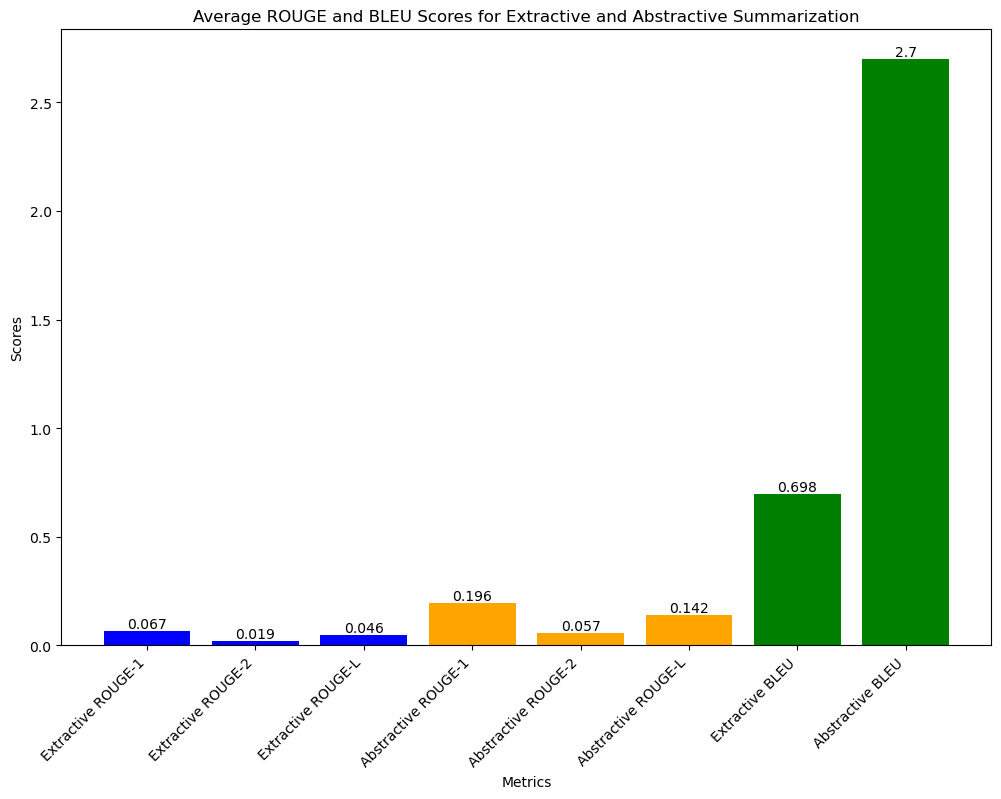

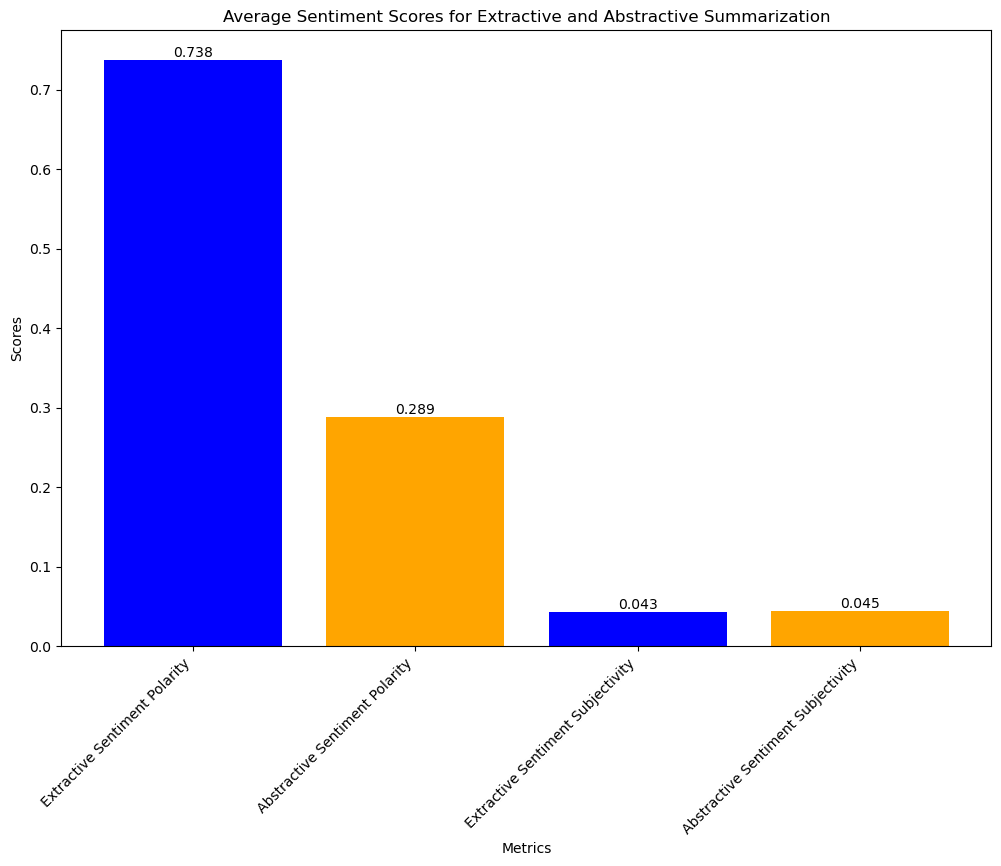

In [7]:
import matplotlib.pyplot as plt

# Calculate average ROUGE and BLEU scores
average_scores = {
    'Extractive ROUGE-1': df['Extractive ROUGE-1'].mean(),
    'Extractive ROUGE-2': df['Extractive ROUGE-2'].mean(),
    'Extractive ROUGE-L': df['Extractive ROUGE-L'].mean(),
    'Abstractive ROUGE-1': df['Abstractive ROUGE-1'].mean(),
    'Abstractive ROUGE-2': df['Abstractive ROUGE-2'].mean(),
    'Abstractive ROUGE-L': df['Abstractive ROUGE-L'].mean(),
    'Extractive BLEU': df['Extractive BLEU'].mean(),
    'Abstractive BLEU': df['Abstractive BLEU'].mean()
}

# Compare ROUGE and BLEU scores
plt.figure(figsize=(12, 8))
bars = plt.bar(average_scores.keys(), average_scores.values(), color=['blue', 'blue', 'blue', 'orange', 'orange', 'orange', 'green', 'green'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Average ROUGE and BLEU Scores for Extractive and Abstractive Summarization')

# Add value labels on bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), ha='center', va='bottom')

plt.show()

# Compare Sentiment Scores
sentiment_scores = {
    'Extractive Sentiment Polarity': df['Extractive Sentiment Polarity'].mean(),
    'Abstractive Sentiment Polarity': df['Abstractive Sentiment Polarity'].mean(),
    'Extractive Sentiment Subjectivity': df['Extractive Sentiment Subjectivity'].mean(),
    'Abstractive Sentiment Subjectivity': df['Abstractive Sentiment Subjectivity'].mean()
}

plt.figure(figsize=(12, 8))
bars = plt.bar(sentiment_scores.keys(), sentiment_scores.values(), color=['blue', 'orange', 'blue', 'orange'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Average Sentiment Scores for Extractive and Abstractive Summarization')

# Add value labels on bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), ha='center', va='bottom')

plt.show()

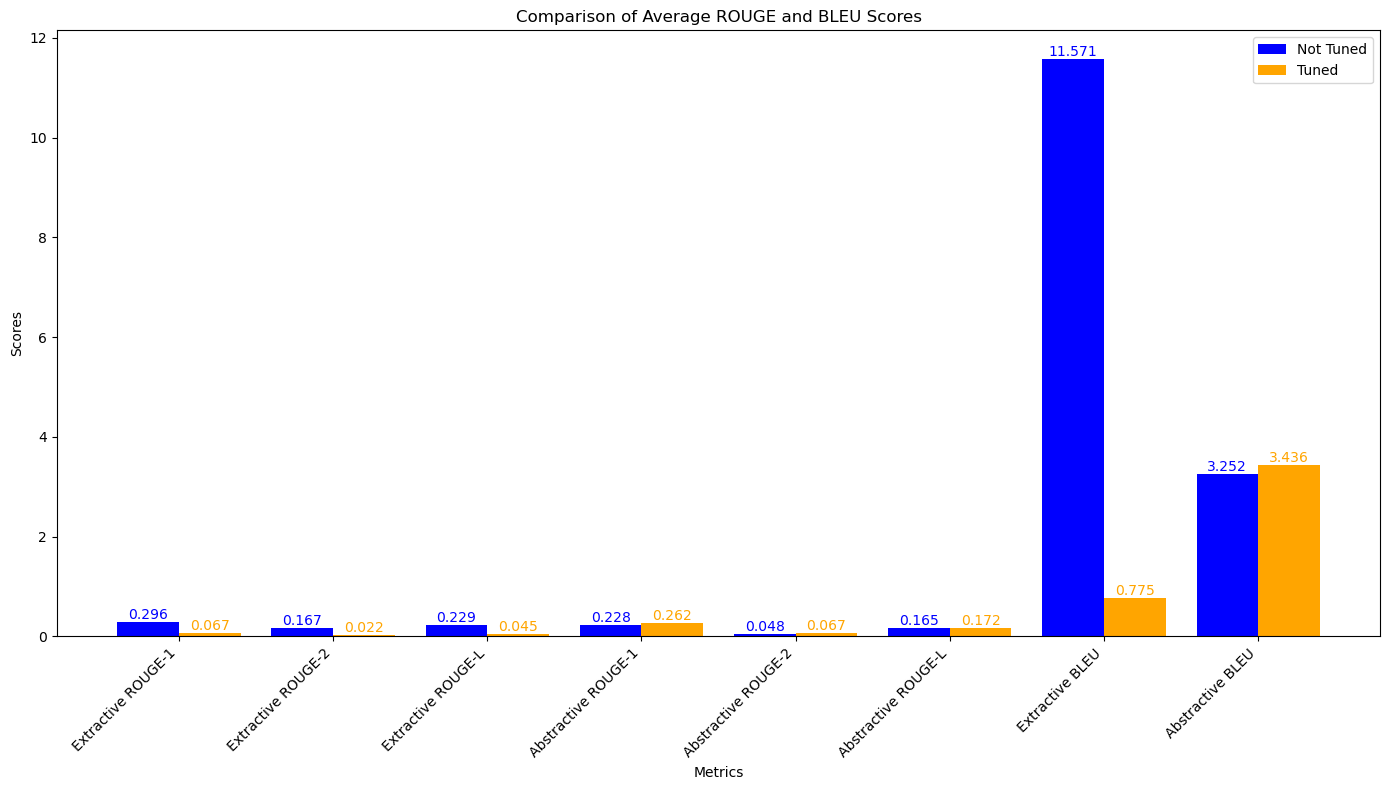

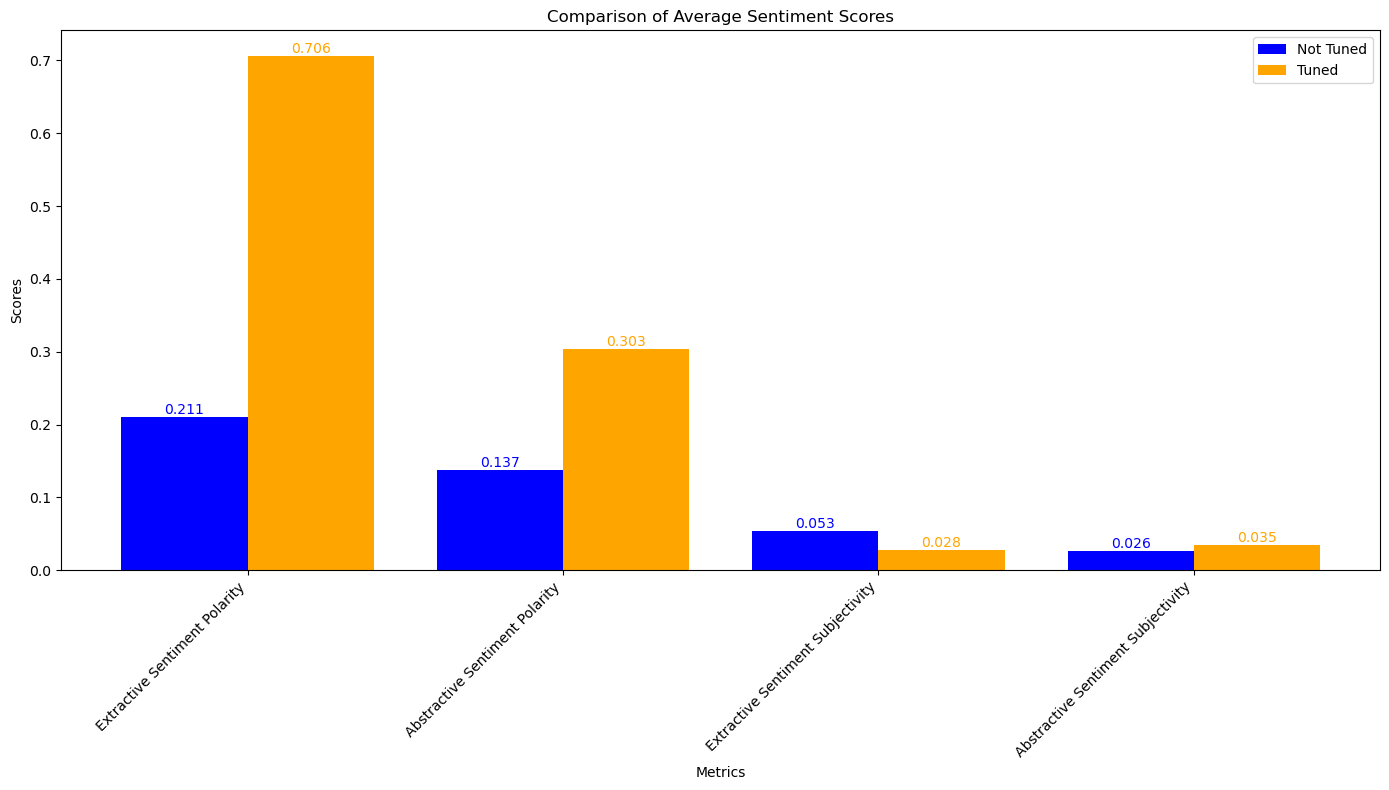

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Function to generate bar charts from CSV files
def generate_bar_charts(ntuned_csv_path, tuned_csv_path):
    # Load the CSV files
    ntuned_data = pd.read_csv(ntuned_csv_path)
    tuned_data = pd.read_csv(tuned_csv_path)

    # Calculate average scores for both datasets
    ntuned_average_scores = {
        'Extractive ROUGE-1': ntuned_data['Extractive ROUGE-1'].mean(),
        'Extractive ROUGE-2': ntuned_data['Extractive ROUGE-2'].mean(),
        'Extractive ROUGE-L': ntuned_data['Extractive ROUGE-L'].mean(),
        'Abstractive ROUGE-1': ntuned_data['Abstractive ROUGE-1'].mean(),
        'Abstractive ROUGE-2': ntuned_data['Abstractive ROUGE-2'].mean(),
        'Abstractive ROUGE-L': ntuned_data['Abstractive ROUGE-L'].mean(),
        'Extractive BLEU': ntuned_data['Extractive BLEU'].mean(),
        'Abstractive BLEU': ntuned_data['Abstractive BLEU'].mean()
    }

    tuned_average_scores = {
        'Extractive ROUGE-1': tuned_data['Extractive ROUGE-1'].mean(),
        'Extractive ROUGE-2': tuned_data['Extractive ROUGE-2'].mean(),
        'Extractive ROUGE-L': tuned_data['Extractive ROUGE-L'].mean(),
        'Abstractive ROUGE-1': tuned_data['Abstractive ROUGE-1'].mean(),
        'Abstractive ROUGE-2': tuned_data['Abstractive ROUGE-2'].mean(),
        'Abstractive ROUGE-L': tuned_data['Abstractive ROUGE-L'].mean(),
        'Extractive BLEU': tuned_data['Extractive BLEU'].mean(),
        'Abstractive BLEU': tuned_data['Abstractive BLEU'].mean()
    }

    # Plot the average ROUGE and BLEU scores for both datasets
    labels = list(ntuned_average_scores.keys())
    ntuned_values = list(ntuned_average_scores.values())
    tuned_values = list(tuned_average_scores.values())

    x = range(len(labels))

    plt.figure(figsize=(14, 8))
    plt.bar(x, ntuned_values, width=0.4, label='Not Tuned', align='center', color='blue')
    plt.bar([p + 0.4 for p in x], tuned_values, width=0.4, label='Tuned', align='center', color='orange')

    plt.xlabel('Metrics')
    plt.ylabel('Scores')
    plt.title('Comparison of Average ROUGE and BLEU Scores')
    plt.xticks([p + 0.2 for p in x], labels, rotation=45, ha='right')
    plt.legend(loc='best')

    # Add value labels on bars
    for i, (ntuned, tuned) in enumerate(zip(ntuned_values, tuned_values)):
        plt.text(i, ntuned, f'{ntuned:.3f}', ha='center', va='bottom', color='blue')
        plt.text(i + 0.4, tuned, f'{tuned:.3f}', ha='center', va='bottom', color='orange')

    plt.tight_layout()
    plt.show()

    # Sentiment Analysis - Average Scores
    ntuned_sentiment_scores = {
        'Extractive Sentiment Polarity': ntuned_data['Extractive Sentiment Polarity'].mean(),
        'Abstractive Sentiment Polarity': ntuned_data['Abstractive Sentiment Polarity'].mean(),
        'Extractive Sentiment Subjectivity': ntuned_data['Extractive Sentiment Subjectivity'].mean(),
        'Abstractive Sentiment Subjectivity': ntuned_data['Abstractive Sentiment Subjectivity'].mean()
    }

    tuned_sentiment_scores = {
        'Extractive Sentiment Polarity': tuned_data['Extractive Sentiment Polarity'].mean(),
        'Abstractive Sentiment Polarity': tuned_data['Abstractive Sentiment Polarity'].mean(),
        'Extractive Sentiment Subjectivity': tuned_data['Extractive Sentiment Subjectivity'].mean(),
        'Abstractive Sentiment Subjectivity': tuned_data['Abstractive Sentiment Subjectivity'].mean()
    }

    # Plot the average Sentiment scores for both datasets
    labels = list(ntuned_sentiment_scores.keys())
    ntuned_values = list(ntuned_sentiment_scores.values())
    tuned_values = list(tuned_sentiment_scores.values())

    x = range(len(labels))

    plt.figure(figsize=(14, 8))
    plt.bar(x, ntuned_values, width=0.4, label='Not Tuned', align='center', color='blue')
    plt.bar([p + 0.4 for p in x], tuned_values, width=0.4, label='Tuned', align='center', color='orange')

    plt.xlabel('Metrics')
    plt.ylabel('Scores')
    plt.title('Comparison of Average Sentiment Scores')
    plt.xticks([p + 0.2 for p in x], labels, rotation=45, ha='right')
    plt.legend(loc='best')

    # Add value labels on bars
    for i, (ntuned, tuned) in enumerate(zip(ntuned_values, tuned_values)):
        plt.text(i, ntuned, f'{ntuned:.3f}', ha='center', va='bottom', color='blue')
        plt.text(i + 0.4, tuned, f'{tuned:.3f}', ha='center', va='bottom', color='orange')

    plt.tight_layout()
    plt.show()

# Replace these paths with the actual paths to your CSV files
ntuned_csv_path = 'C:/Users/Sujan Tumbaraguddi/Desktop/Data Science/Assignments/3_7150 - Project/DATA/NTuned_summarized_reports_evaluation.csv'
tuned_csv_path = 'C:/Users/Sujan Tumbaraguddi/Desktop/Data Science/Assignments/3_7150 - Project/DATA/Tuned_summarized_reports_evaluation.csv'

# Call the function with your file paths
generate_bar_charts(ntuned_csv_path, tuned_csv_path)


[nltk_data] Downloading package vader_lexicon to C:\Users\Sujan
[nltk_data]     Tumbaraguddi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package vader_lexicon to C:\Users\Sujan
[nltk_data]     Tumbaraguddi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


           India  New Zealand  Australia   England  South Africa
01.txt  0.079112     0.000000   0.000000  0.000000     -0.114820
02.txt  0.165687     0.000000   0.000000 -0.086500      0.273200
03.txt  0.000000     0.000000   0.000000  0.000000      0.005267
04.txt  0.000000     0.000000   0.305867  0.000000      0.000000
05.txt  0.048055     0.000000   0.347514  0.000000      0.000000
06.txt  0.401900     0.000000   0.000000  0.000000      0.207486
07.txt  0.417300     0.000000  -0.139000  0.266200      0.506125
08.txt -0.020367     0.000000   0.000000  0.000000      0.000000
09.txt  0.000000     0.000000   0.000000  0.556300     -0.419400
10.txt  0.000000     0.000000   0.000000  0.123450     -0.084950
11.txt  0.000000     0.000000   0.001950  0.000000      0.000000
12.txt  0.061829     0.000000   0.000000  0.000000      0.000000
13.txt -0.241900     0.000000   0.000000  0.242512      0.000000
14.txt  0.000000     0.000000   0.000000  0.000000      0.100433
15.txt  0.000000     0.57

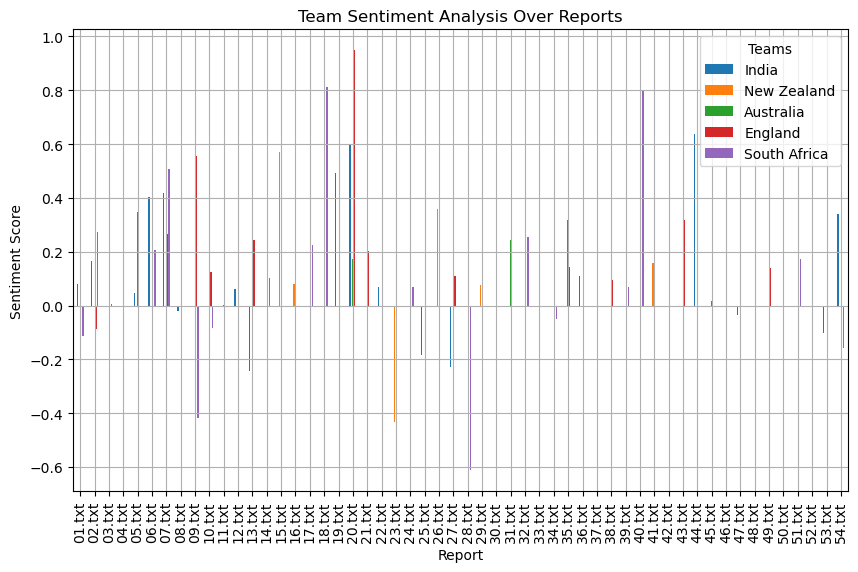

In [13]:
import nltk
nltk.download('vader_lexicon')
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt

# Download the VADER lexicon
nltk.download('vader_lexicon')

# Initialize the sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Paths to the directories containing the reports
reports_path = 'C:/Users/Sujan Tumbaraguddi/Desktop/Data Science/Assignments/3_7150 - Project/DATA/reports'

# Function to read text files from a specified folder
def read_text_files(path):
    paths = glob.glob(os.path.join(path, "*.txt"))
    documents = {}
    for path in paths:
        with open(path, encoding='utf-8') as file:
            documents[os.path.basename(path)] = file.read()
    return documents

# Reading all reports
reports = read_text_files(reports_path)

# List of teams to track
teams = ['India', 'New Zealand', 'Australia', 'England', 'South Africa']  # Add more teams as needed

# Function to analyze sentiment of sentences mentioning a team
def analyze_team_sentiment(reports, teams):
    team_sentiments = {team: [] for team in teams}

    for doc_name, report in reports.items():
        sentences = sent_tokenize(report)
        for team in teams:
            team_sentiment = []
            for sentence in sentences:
                if team in sentence:
                    sentiment = sid.polarity_scores(sentence)
                    team_sentiment.append(sentiment['compound'])
            if team_sentiment:
                average_sentiment = sum(team_sentiment) / len(team_sentiment)
                team_sentiments[team].append(average_sentiment)
            else:
                team_sentiments[team].append(0)  # Use 0 for neutral sentiment when no mention

    return team_sentiments

# Analyze sentiment for each team
team_sentiments = analyze_team_sentiment(reports, teams)

# Convert to DataFrame for easier analysis and visualization
sentiment_df = pd.DataFrame(team_sentiments, index=reports.keys())
print(sentiment_df)

# Plotting
sentiment_df.plot(kind='bar', figsize=(10, 6))
plt.title('Team Sentiment Analysis Over Reports')
plt.xlabel('Report')
plt.ylabel('Sentiment Score')
plt.legend(title='Teams')
plt.grid(True)
plt.show()
